In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm

Would you believe me if I said you don't NumPy or SciPy to do data simulation in Python?

Simple normal model.

$$
\begin{aligned}
Y_i     &\sim \text{Normal}(\mu, \sigma^2) \\
\mu &\sim \text{Normal}(0, 1^2) \\
\sigma  &\sim \text{Gamma}(2, 2)
\end{aligned}
$$

with $i = 1, \dots, N$

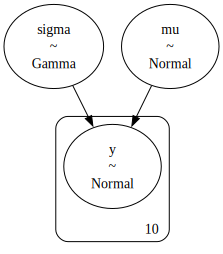

In [2]:
N = 10

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sigma = pm.Gamma("sigma", alpha=2, beta=2)
    pm.Normal("y", mu=mu, sigma=sigma, shape=N)

model.to_graphviz()

In [3]:
pm.draw(mu)

array(-0.43949984)

In [4]:
pm.draw(sigma, random_seed=1)

array(0.48457823)

In [5]:
mu_value, sigma_value = pm.draw([mu, sigma], random_seed=1)
mu_value, sigma_value

(array(2.48568021), array(0.48457823))

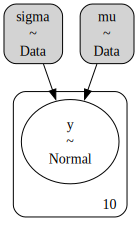

In [6]:
model_do = pm.do(model, {"mu": mu_value, "sigma": sigma_value})
model_do.to_graphviz()

In [7]:
y_values = pm.draw(model_do["y"], random_seed=12)
y_values

array([1.94911996, 2.48090434, 2.45889102, 3.18381165, 2.20324009,
       2.95533303, 2.24277297, 2.14773919, 3.42044625, 2.46784848])

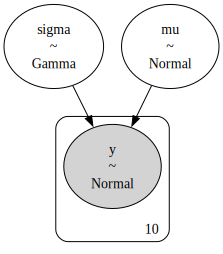

In [8]:
model_observed = pm.observe(model, {"y": y_values})
model_observed.to_graphviz()

In [9]:
with model_observed:
    idata = pm.sample(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


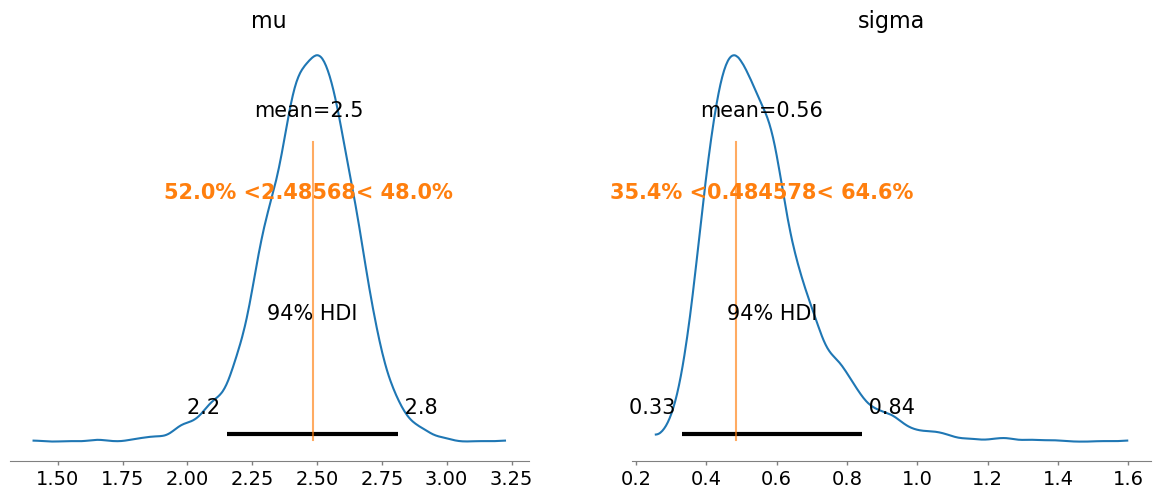

In [10]:
az.plot_posterior(idata, ref_val=[mu_value, sigma_value]);

Simple linear regression model.

$$
\begin{aligned}
Y_i \mid \mu_i &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \alpha + \beta x_i \\
\alpha &\sim \text{Normal}(0, 1^2) \\
\beta &\sim \text{Normal}(0, 1^2) \\
\sigma  &\sim \text{Gamma}(2, 2)
\end{aligned}
$$

with $i = 1, \dots, N$

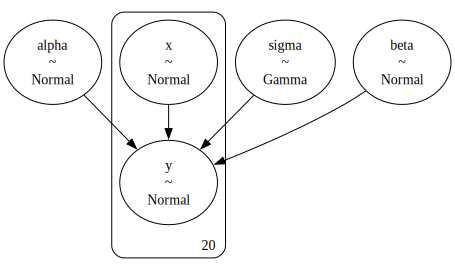

In [11]:
N = 20

with pm.Model() as model:
    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta")
    x = pm.Normal("x", shape=N)

    mu = alpha + beta * x
    sigma = pm.Gamma("sigma", alpha=2, beta=2)

    pm.Normal("y", mu=mu, sigma=sigma, shape=N)

model.to_graphviz()

In [12]:
alpha_value, beta_value, sigma_value, x_values = pm.draw([alpha, beta, sigma, x], random_seed=2)

In [13]:
alpha_value, beta_value, sigma_value

(array(0.36634198), array(1.48170791), array(1.03700209))

In [14]:
x_values

array([-1.07560011, -0.20248617, -0.48915916,  1.85426728, -0.33322773,
       -0.60545135, -0.77415408, -0.67710521,  0.95335734,  0.80871038,
        1.25316838, -0.07747906,  0.67752489, -1.85521597, -0.08532557,
       -0.33926094, -0.34302005, -1.07345858, -0.55485505,  1.03992364])

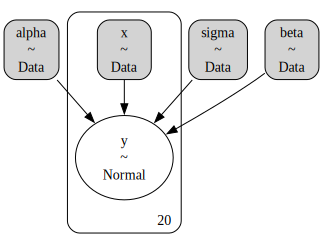

In [15]:
model_do = pm.do(model, {"alpha": alpha_value, "beta": beta_value, "sigma": sigma_value, "x": x_values})
model_do.to_graphviz()

In [16]:
with model_do:
    idata_sim = pm.sample_prior_predictive(samples=1)
idata_sim.prior["y"].to_numpy().flatten()

Sampling: [y]


array([ 0.73756468, -3.37579057,  1.016991  ,  1.58767779, -0.11599467,
       -1.90223119,  0.14794932, -0.94375803,  0.49417392,  1.23443961,
        1.39990779,  1.79792073, -0.82810829, -3.62873534,  0.61772791,
       -0.31314614,  0.92811233, -2.92008469,  0.694696  ,  1.13406409])

In [17]:
y_values = pm.draw(model_do["y"])
y_values

array([-2.55561336,  1.50519703, -0.20170715,  3.1730006 , -0.48401169,
        1.75815567, -1.24296297, -1.88807283,  1.40262723,  2.19159939,
        3.69939608, -0.8851738 ,  1.3305562 , -1.55570748,  0.13370599,
        0.89589151, -0.15316258, -0.72081994, -1.0118156 ,  2.2392842 ])

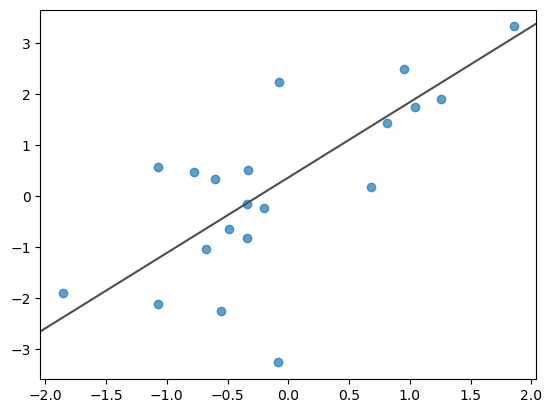

In [18]:
fig, ax = plt.subplots()
ax.scatter(x_values, pm.draw(model_do["y"]), alpha=0.7)
ax.axline((0, alpha_value), slope=beta_value, color="0.3");

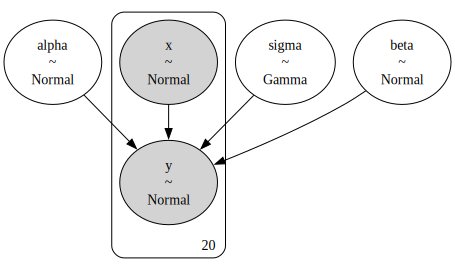

In [19]:
model_observed = pm.observe(model, {"x": x_values, "y": y_values})
model_observed.to_graphviz()

In [20]:
with model_observed:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


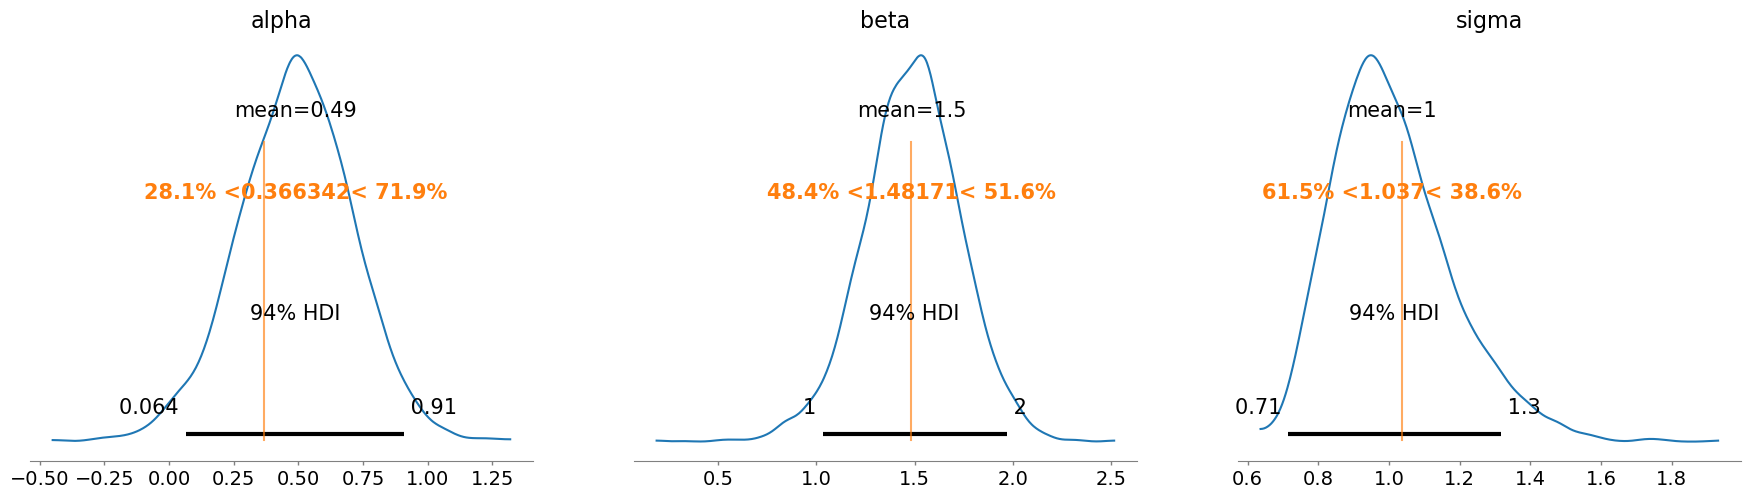

In [21]:
az.plot_posterior(idata, ref_val=[alpha_value, beta_value, sigma_value]);

In [22]:
posterior_draws = az.extract(
    idata, group="posterior", var_names=["alpha", "beta"], num_samples=15
)
posterior_draws

<xarray.Dataset> Size: 600B
Dimensions:  (sample: 15)
Coordinates:
  * sample   (sample) object 120B MultiIndex
  * chain    (sample) int64 120B 1 2 0 2 0 3 1 0 1 1 3 2 3 0 3
  * draw     (sample) int64 120B 110 931 837 940 130 47 ... 994 136 103 97 423
Data variables:
    alpha    (sample) float64 120B 0.7634 0.747 0.1959 ... 0.2728 0.5466 0.06304
    beta     (sample) float64 120B 1.14 1.247 1.473 1.559 ... 1.463 1.71 1.9
Attributes:
    created_at:                 2024-10-31T22:38:41.668471+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.17.0
    sampling_time:              1.6408402919769287
    tuning_steps:               1000

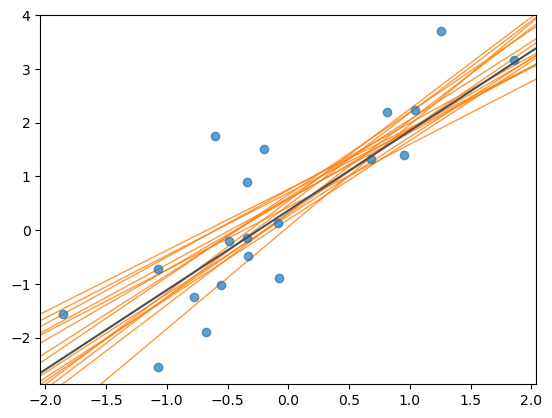

In [23]:
fig, ax = plt.subplots()
ax.scatter(x_values, y_values, alpha=0.7)
ax.axline((0, alpha_value), slope=beta_value, color="0.3")

for a, b in zip(posterior_draws["alpha"].to_numpy(), posterior_draws["beta"].to_numpy()):
    ax.axline((0, a), slope=b, color="C1", alpha=0.8, lw=1, zorder=-1)

---

* Multiple normal means (indexing and dims).
* A complex logistic regression model, with continuous and categorical predictors, and perhaps zero sum normal.

In [24]:
J = 6
N = 20
coords = {"group": [f"group {i}" for i in range(J)]}

---

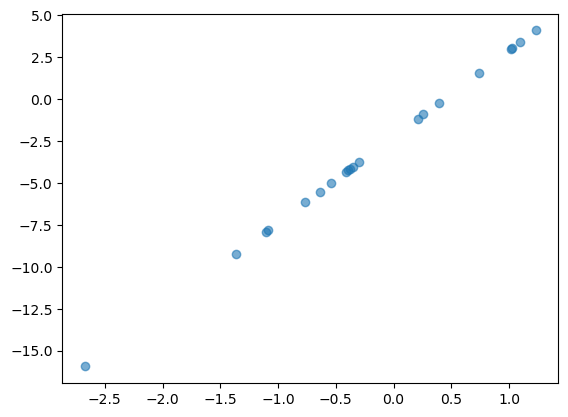

In [25]:
import pymc as pm
import matplotlib.pyplot as plt

N = 20

with pm.Model() as model:
    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta")
    x = pm.Normal("x", shape=N)

    mu = alpha + beta * x
    sigma = pm.Gamma("sigma", alpha=2, beta=2)

    pm.Normal("y", mu=mu, sigma=sigma, shape=N)

alpha_value, beta_value, sigma_value, x_values = pm.draw([alpha, beta, sigma, x], random_seed=1)
model_do = pm.do(model, {"alpha": alpha_value, "beta": beta_value, "sigma": sigma_value, "x": x_values})
y_values = pm.draw(model_do["y"], random_seed=1)

plt.scatter(x_values, y_values, alpha=0.6);